## Exp 7: a simple classifier with the barcode dataset
### use LSTM instead of fully connected

In [1]:
from __future__ import print_function
from __future__ import absolute_import
import matplotlib.pyplot as plt

import sugartensor as tf
import os
from IPython.display import display, Image
import numpy as np
from scipy import ndimage
from six.moves import cPickle as pickle

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"
%matplotlib inline


In [2]:
batch_size = 1   # batch size
image_size = 64
pixel_depth = 255.0

## Training data

-0.473099324544
1500
2.0


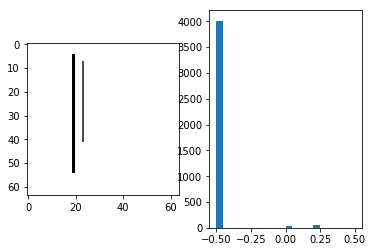

In [3]:
dir= "barcode/train/"
fn = os.listdir(dir)
total = len(fn)
total
#     change the range to switch between exp2 : [0, 1, 2, 3, 4, 5, 6]
#     and exp2.1: [1, 3, 5, 7, 9]
visible = [1, 2, 4, 7, 9]
# put all the images into this blob of size total*size*size*1
# REMEMBER to change shape of dataset
training_dataset = np.ndarray(shape = (300*len(visible), image_size, image_size, 1), dtype = np.float32)
counter = 0
# REMEMBER to change shape of training label
training_label = np.ndarray(shape = (300*len(visible)), dtype = np.float32)
for file in fn:
#     image_data = ndimage.imread(dir+file).astype(float)
    image_data = (ndimage.imread(dir+file).astype(float) - 255/2) / pixel_depth
    label = int(file.split("_")[0])
    if label in visible:
        training_label[counter] = label
        training_dataset[counter, :, :] = image_data[:,:,0].reshape(image_size, image_size, 1)
        counter+=1
#     else:
#         print(file[0])
# shuffle dataset
permutation = np.random.permutation(counter)
training_dataset = training_dataset[permutation,:,:,:]
training_label = training_label[permutation]


print(np.sum(training_dataset)/(300*len(visible)*image_size*image_size))
print(len(training_label))
%matplotlib inline

# We'll show the image and its pixel value histogram side-by-side.
_, (ax1, ax2) = plt.subplots(1, 2)

# To interpret the values as a 28x28 image, we need to reshape
# the numpy array, which is one dimensional.
image = training_dataset[100]
print(training_label[100])
ax1.imshow(image.reshape(image_size, image_size), cmap=plt.cm.Greys);

ax2.hist(image.reshape(image_size*image_size), bins=20, range=[-0.5, 0.5]);

In [4]:
train_data_node = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, 1))

train_labels_node = tf.placeholder(tf.float32, shape =(batch_size, 1))

def print_variable():
    for v in tf.global_variables():
        print(v)
# capping stddev at 0.1 is important to avoid exploding value
def conv_relu(input, kernel_shape, bias_shape, stride = 2):
    weights = tf.get_variable("weights", kernel_shape, initializer=tf.truncated_normal_initializer(stddev=0.1))
    biases = tf.get_variable("biases", bias_shape, initializer=tf.constant_initializer(0.0))
    conv = tf.nn.conv2d(input, weights, strides = [1, stride, stride, 1], padding = 'SAME')
    return tf.nn.relu(conv+biases)
def fully_connected(input, out_shape):
    input_shape = input.get_shape().as_list()
    batch = input_shape[0]
    flattened_size = input_shape[1]
    weights = tf.get_variable("weights", [flattened_size, out_shape], 
                              initializer=tf.truncated_normal_initializer(stddev=0.1))
    biases = tf.get_variable("biases", [out_shape],
                            initializer = tf.constant_initializer(0.1))
    return tf.matmul(input, weights) + biases
def network(input_images):
    with tf.variable_scope("conv1"):
        # kernel is in shape height*width*in*out
        conv_relu1 = conv_relu(input_images, [4, 4, 1, 32], [32])
    with tf.variable_scope("conv2"):
        conv_relu2 = conv_relu(conv_relu1, [4, 4, 32, 64], [64])
    with tf.variable_scope("conv3"):
        conv_relu3 = conv_relu(conv_relu2, [4, 4, 64, 128], [128])
    with tf.variable_scope("fc1"):
        conv_relu3_shape = conv_relu3.get_shape().as_list()
        reshape_conv3 = tf.reshape(conv_relu3,
                                [conv_relu3_shape[0], conv_relu3_shape[1]*conv_relu3_shape[2]*conv_relu3_shape[3]])
        fc1 = tf.nn.relu(fully_connected(reshape_conv3, 1024))
    with tf.variable_scope("lstm"):
        num_hidden = 30
        fc1_shape = fc1.get_shape().as_list()
        print(fc1_shape)
        fc1_reshape = tf.reshape(fc1, [fc1_shape[0], fc1_shape[1], 1])
        cell = tf.contrib.rnn.LSTMCell(num_hidden, state_is_tuple=True)
        val, _ = tf.nn.dynamic_rnn(cell, fc1_reshape, dtype = tf.float32)
        print(val)
        val = tf.transpose(val, [1, 0, 2]) #transpose to easily get the last state
        last = tf.gather(val, int(val.get_shape()[0]) - 1)
        print(last)
        weight = tf.Variable(tf.truncated_normal([num_hidden, 1]))
        bias = tf.Variable(tf.constant(0.1, shape=[1]))
        output = tf.matmul(last, weight)+bias
    return output
    
output = network(train_data_node)

loss = tf.reduce_mean(tf.squared_difference(output, train_labels_node))

train_size = len(training_label)

batch = tf.Variable(0)
# Decay once per epoch, using an exponential schedule starting at 0.01.
learning_rate = tf.train.exponential_decay(
  0.0001,                # Base learning rate.
  batch * batch_size,  # Current index into the dataset.
  train_size,          # Decay step. Decay after every epoch (seeing all example)
  0.95,                # Decay rate.
  staircase=True)
# Use simple momentum for the optimization.
optimizer = tf.train.AdamOptimizer(learning_rate,
                                       0.9).minimize(loss,
                                                     global_step=batch)
# saver
saver = tf.train.Saver()

[1, 1024]
Tensor("lstm/rnn/transpose:0", shape=(1, 1024, 30), dtype=float32)
Tensor("lstm/Gather:0", shape=(1, 30), dtype=float32)


In [5]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8)

sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
sess.as_default()

tf.global_variables_initializer().run()

In [6]:
batch_data = training_dataset[:batch_size]
batch_labels = training_label[:batch_size].reshape((batch_size, 1))


_, l, lr, predictions = sess.run(
  [optimizer, loss, learning_rate, output],
  feed_dict={train_data_node: batch_data,
             train_labels_node: batch_labels})

print("Done")

Done


In [7]:
print_variable()

<tf.Variable 'global_step:0' shape=() dtype=int32_ref>
<tf.Variable 'conv1/weights:0' shape=(4, 4, 1, 32) dtype=float32_ref>
<tf.Variable 'conv1/biases:0' shape=(32,) dtype=float32_ref>
<tf.Variable 'conv2/weights:0' shape=(4, 4, 32, 64) dtype=float32_ref>
<tf.Variable 'conv2/biases:0' shape=(64,) dtype=float32_ref>
<tf.Variable 'conv3/weights:0' shape=(4, 4, 64, 128) dtype=float32_ref>
<tf.Variable 'conv3/biases:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'fc1/weights:0' shape=(8192, 1024) dtype=float32_ref>
<tf.Variable 'fc1/biases:0' shape=(1024,) dtype=float32_ref>
<tf.Variable 'lstm/rnn/lstm_cell/weights:0' shape=(31, 120) dtype=float32_ref>
<tf.Variable 'lstm/rnn/lstm_cell/biases:0' shape=(120,) dtype=float32_ref>
<tf.Variable 'lstm/Variable:0' shape=(30, 1) dtype=float32_ref>
<tf.Variable 'lstm/Variable_1:0' shape=(1,) dtype=float32_ref>
<tf.Variable 'Variable:0' shape=() dtype=int32_ref>
<tf.Variable 'beta1_power:0' shape=() dtype=float32_ref>
<tf.Variable 'beta2_power:0' s

In [8]:
var_23 = [v for v in tf.global_variables() if v.name == "conv1/weights:0"][0]
print(sess.run(var_23))

[[[[ -7.89803118e-02  -1.21675152e-02  -4.95274775e-02   1.07643314e-01
      5.73780090e-02   5.83476052e-02  -1.65676884e-02  -2.49315109e-02
      9.04787257e-02   1.35800764e-01   2.06526872e-02  -2.35942770e-02
     -3.83983515e-02   2.58202311e-02  -1.72606185e-02  -7.92349875e-02
      9.87638906e-02  -4.21011113e-02  -1.79561883e-01   8.05536434e-02
      1.29138045e-02  -7.35469833e-02  -1.01056799e-01  -9.44861956e-03
      2.55274940e-02   9.42687318e-02  -8.39719549e-02   1.07856616e-01
     -3.94647680e-02  -7.00023770e-02   6.98408810e-03  -6.32590652e-02]]

  [[ -8.84250272e-03   1.59717113e-01  -7.24000633e-02  -5.12794480e-02
     -9.80418622e-02  -6.13768138e-02  -1.08742334e-01   9.03631672e-02
      1.35953315e-02  -3.71858105e-02  -3.77685055e-02   3.20069455e-02
      8.89291801e-03   1.82385780e-02   2.98651736e-02   9.79079232e-02
     -1.07868917e-01   1.53986260e-01   4.89352690e-03  -8.42698291e-02
     -6.89805299e-02   1.08283786e-02  -1.14174630e-03  -9.70

In [9]:
directory = 'pureTensorflowExp/Exp7/'
if not os.path.exists(directory):
    os.makedirs(directory)

for step in range(20000):
    offset = (step * batch_size) % (train_size - batch_size)
    batch_data = training_dataset[offset:batch_size+offset]
    batch_labels = training_label[offset:batch_size+offset].reshape((batch_size, 1))
    
    _, l, lr, predictions = sess.run(
      [optimizer, loss, learning_rate, output],
      feed_dict={train_data_node: batch_data,
             train_labels_node: batch_labels})
    
    if step % 500 ==0:
        print('Step %d' %step)
        print(predictions)
        print('Mini-batch loss: %.5f Learning rate: %.5f' % (l, lr))
        
        save_path = saver.save(sess, directory+str(step)+".ckpt")

Step 0
[[ 0.67851555]]
Mini-batch loss: 69.24711 Learning rate: 0.00010
Step 500
[[ 5.4316597]]
Mini-batch loss: 2.45969 Learning rate: 0.00010
Step 1000
[[ 7.63662004]]
Mini-batch loss: 1.85880 Learning rate: 0.00010
Step 1500
[[ 4.60928297]]
Mini-batch loss: 0.37123 Learning rate: 0.00009
Step 2000
[[ 8.04926205]]
Mini-batch loss: 0.90390 Learning rate: 0.00009
Step 2500
[[ 1.75813651]]
Mini-batch loss: 0.05850 Learning rate: 0.00009
Step 3000
[[ 8.12409496]]
Mini-batch loss: 0.76721 Learning rate: 0.00009
Step 3500
[[ 1.52729464]]
Mini-batch loss: 0.27804 Learning rate: 0.00009
Step 4000
[[ 8.1949749]]
Mini-batch loss: 0.64807 Learning rate: 0.00009
Step 4500
[[ 1.35904121]]
Mini-batch loss: 0.12891 Learning rate: 0.00009
Step 5000
[[ 1.28286052]]
Mini-batch loss: 0.08001 Learning rate: 0.00009
Step 5500
[[ 1.22277617]]
Mini-batch loss: 0.04963 Learning rate: 0.00009
Step 6000
[[ 1.74584019]]
Mini-batch loss: 0.06460 Learning rate: 0.00008
Step 6500
[[ 1.60189879]]
Mini-batch loss: 

# Validation


In [10]:
for step in range(10000):
    offset = (step * batch_size) % (train_size - batch_size)
    batch_data = training_dataset[offset:batch_size+offset]
    batch_labels = training_label[offset:batch_size+offset].reshape((batch_size, 1))
    
    _, l, lr, predictions = sess.run(
      [optimizer, loss, learning_rate, output],
      feed_dict={train_data_node: batch_data,
             train_labels_node: batch_labels})
    
    if step % 500 ==0:
        print('Step %d' %step)
        print(predictions)
        print('Mini-batch loss: %.5f Learning rate: %.5f' % (l, lr))
        
        save_path = saver.save(sess, directory+str(step+10000)+".ckpt")



Step 0
[[ 8.96471882]]
Mini-batch loss: 0.00124 Learning rate: 0.00005
Step 500
[[ 7.00948]]
Mini-batch loss: 0.00009 Learning rate: 0.00005
Step 1000
[[ 9.04354572]]
Mini-batch loss: 0.00190 Learning rate: 0.00005
Step 1500
[[ 4.06181622]]
Mini-batch loss: 0.00382 Learning rate: 0.00005
Step 2000
[[ 8.97570419]]
Mini-batch loss: 0.00059 Learning rate: 0.00005
Step 2500
[[ 1.78442633]]
Mini-batch loss: 0.04647 Learning rate: 0.00005
Step 3000
[[ 9.01585865]]
Mini-batch loss: 0.00025 Learning rate: 0.00005
Step 3500
[[ 0.92336667]]
Mini-batch loss: 0.00587 Learning rate: 0.00005
Step 4000
[[ 8.95482063]]
Mini-batch loss: 0.00204 Learning rate: 0.00004
Step 4500
[[ 1.05067241]]
Mini-batch loss: 0.00257 Learning rate: 0.00004
Step 5000
[[ 0.94882911]]
Mini-batch loss: 0.00262 Learning rate: 0.00004
Step 5500
[[ 1.0834018]]
Mini-batch loss: 0.00696 Learning rate: 0.00004
Step 6000
[[ 2.13239098]]
Mini-batch loss: 0.01753 Learning rate: 0.00004
Step 6500
[[ 1.82527566]]
Mini-batch loss: 0.0